In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc # importing also inspect and desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [7]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# another option is to use base.classes.keys() to get a list of all of the classes that automap found.
Base.classes.keys()

['measurement', 'station']

In [9]:
# Using the inspector to print the column names within the 'Salaries' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print("Most recent date in the data set is: ", recent_date)

Most recent date in the data set is:  2017-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(first_date)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date > first_date)
    .order_by(measurement.date)
    .all()
)
precipitation_data

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

In [16]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])
precipitation_df = precipitation_df.sort_values("Date").dropna()

precipitation_df

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15
...,...,...
2218,2017-08-22,0.50
2221,2017-08-23,0.08
2219,2017-08-23,0.00
2220,2017-08-23,0.00


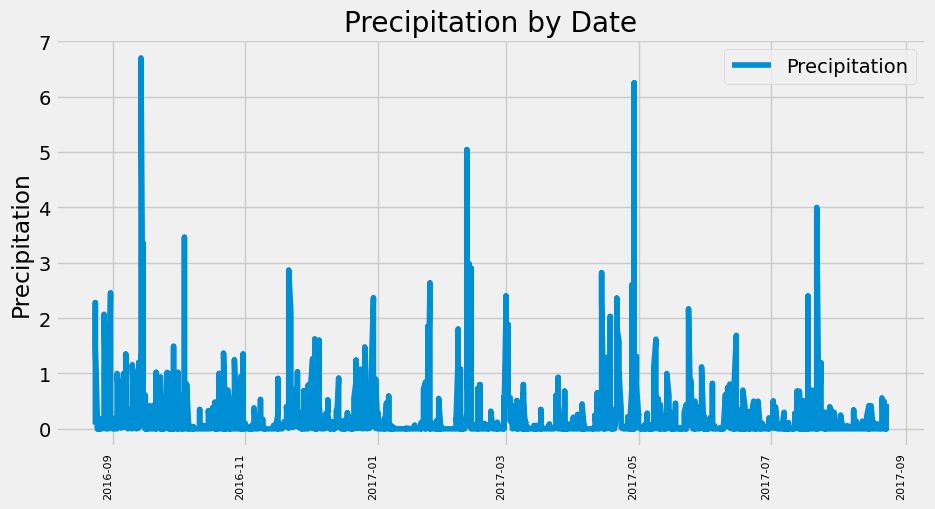

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10,6))
plt.xlabel('', fontsize=8)
plt.ylabel('Precipitation')
plt.title('Precipitation by Date')
plt.xticks(rotation=90, fontsize=8)
plt.savefig('Precipitation_by_Date.png')
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics=precipitation_df.describe()
print(summary_statistics)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
no_stations = session.query(station).count()
print(f"Number of Stations = {no_stations}")

Number of Stations = 9


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)) \
                         .group_by(measurement.station) \
                         .order_by(desc(func.count(measurement.station))) \
                         .all()
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
max_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').first()

print("Temperature statistics for the most active station:")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Temperature statistics for the most active station:
Lowest Temperature: (54.0,)
Highest Temperature: (85.0,)
Average Temperature: (71.66378066378067,)


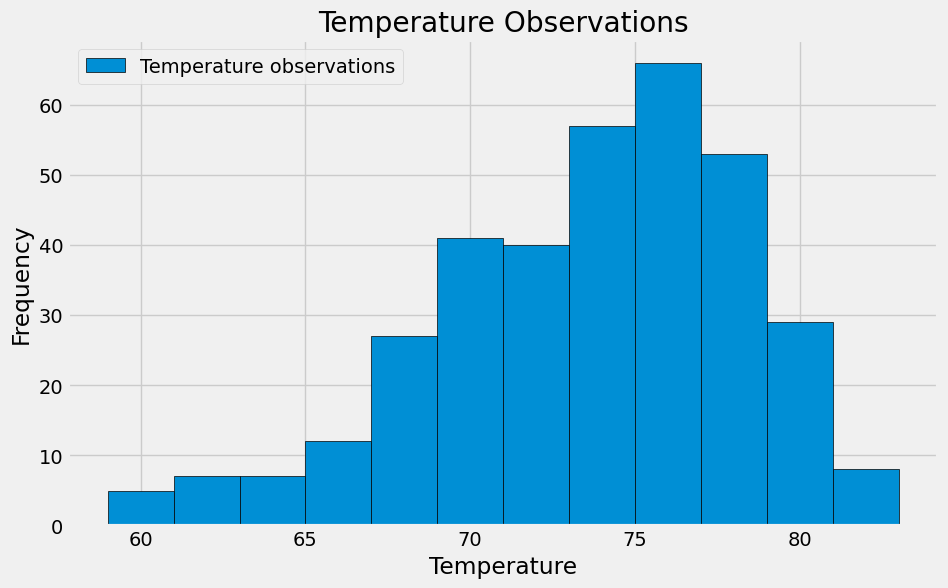

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(measurement.tobs)\
        .filter(measurement.station == 'USC00519281')\
        .filter(measurement.date >= first_date).all()
temperature_df = pd.DataFrame(data, columns=['Temperature observations'])

temperature_df.plot.hist(bins=12, figsize=(10, 6), edgecolor = 'black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations')
plt.savefig('Temperature Observations.png')
plt.show()

# Close Session

In [24]:
# Close Session
session.close()